## Mean Normalization 

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P datasets
!tar xf datasets/cifar-10-python.tar.gz -C datasets

In [2]:
with open('datasets/cifar-10-batches-py/data_batch_1', 'rb') as input_file: 
    X = pickle.load(input_file, encoding='latin1')

--2019-04-11 12:32:58--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: 'cifar-10-python.tar.gz.1'

cifar-10-python.tar   0%[                    ] 264.00K   156KB/s               ^C


In [13]:
with open('datasets/cifar-10-batches-py/data_batch_1', 'rb') as input_file: 
    X = pickle.load(input_file, encoding='latin1')

In [14]:
X.keys()

dict_keys(['batch_label', 'labels', 'data', 'filenames'])

In [15]:
X = X['data']

In [16]:
X.shape

(10000, 3072)

In [17]:
X = X.reshape((-1, 3, 32, 32))

X.shape

(10000, 3, 32, 32)

In [18]:
X = X.transpose(0, 2, 3, 1)

X.shape

(10000, 32, 32, 3)

In [19]:
X = X.reshape(-1, 3 * 32 * 32) 

X.shape

(10000, 3072)

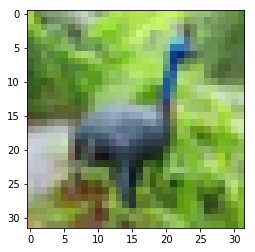

In [20]:
plt.imshow(X[6].reshape(32, 32, 3))

plt.show()

## Normalization
* zero-centre the data :this calculates the mean separately across pixels and colour channels
* divide by std

In [21]:
X = X - X.mean(axis=0)

In [22]:
X = X / np.std(X, axis=0) 

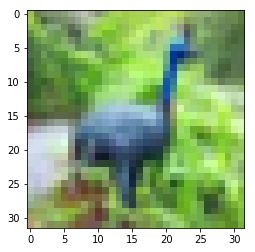

In [23]:
def show(i):
    i = i.reshape((32, 32, 3))

    m, M = i.min(), i.max()
    
    plt.imshow((i - m) / (M - m))
    plt.show()

show(X[6])

### ZCA whitening
Whitening is a transformation of data in such a way that its covariance matrix Σ is the identity matrix. Hence whitening decorrelates features. It is used as a preprocessing method.  Principal component analysis (PCA) and Zero-phase component analysis (ZCA) are the two ways to do this.

* compute the covariance of the image data
* perform singular value decomposition (These steps take time)
* build the ZCA matrix
* transform the image data  

In [45]:
X_subset = X[:1000]

X_subset.shape

(1000, 3072)

In [46]:
cov = np.cov(X_subset, rowvar=True)   

In [47]:
cov.shape

(1000, 1000)

In [48]:
U, S, V = np.linalg.svd(cov)     

In [49]:
print(U.shape)
print(S.shape)
print(V.shape)

(1000, 1000)
(1000,)
(1000, 1000)


In [50]:
epsilon = 1e-5

zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

In [51]:
zca_matrix.shape

(1000, 1000)

In [52]:
zca = np.dot(zca_matrix, X_subset)   

In [53]:
zca.shape

(1000, 3072)

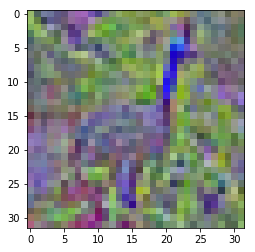

In [54]:
show(zca[6])

## Pre-processing in PyTorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', download=True, transform=transform)

Files already downloaded and verified


In [5]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./datasets/cifar10/train
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16,
                                         shuffle=True, 
                                         num_workers=2)

### Viewing the images

In [7]:
images_batch, labels_batch = iter(dataloader).next()

In [8]:
images_batch.shape

torch.Size([16, 3, 256, 256])

In [ ]:
labels_batch.shape

In [ ]:
labels_batch

In [9]:
img = torchvision.utils.make_grid(images_batch)

In [10]:
img.shape

torch.Size([3, 518, 2066])

In [14]:
img = np.transpose(img, (1, 2, 0))

In [15]:
img.shape

torch.Size([518, 2066, 3])

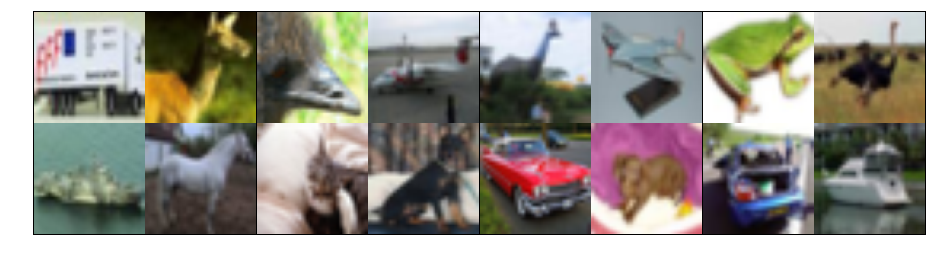

In [16]:
plt.figure (figsize = (16, 12))

plt.imshow(img)
plt.axis('off')
plt.show()

## Normalization

Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation

* Finding mean and std

In [17]:
pop_mean = []
pop_std = []

In [18]:
for i, data in enumerate(dataloader, 0):
    
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy() 
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

In [ ]:
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

In [19]:
pop_mean.shape, pop_std.shape

((3125, 3), (3125, 3))

In [20]:
# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)

pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

In [21]:
print(pop_mean)
print(pop_std)

[0.49159038 0.4823453  0.44671997]
[0.23833168 0.23495147 0.25272548]


### Applying transforms 

In [181]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(pop_mean, 
                                 pop_std)
            ])

In [182]:
trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [183]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

In [184]:
images_batch, labels_batch = iter(trainloader).next()

In [185]:
images_batch.shape

torch.Size([16, 3, 224, 224])

### Viewing the images

In [186]:
img = torchvision.utils.make_grid(images_batch)

img.shape

torch.Size([3, 454, 1810])

In [187]:
img = np.transpose(img, (1, 2, 0))

img.shape

torch.Size([454, 1810, 3])

In [188]:
m, M = img.min(), img.max()

m, M

(tensor(-1.9892), tensor(2.1268))

In [189]:
# Ensure floating point image RGB values must be in the 0..1 range.

img = (1/(abs(m) * M)) * img + 0.5 

In [190]:
img

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.0373, 0.0395, 0.1001],
         ...,
         [0.4613, 0.4735, 0.4934],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        ...,

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.8666, 0.9380, 0.9682],
         ...,
         [0.8253, 0.7400, 0.5820],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.

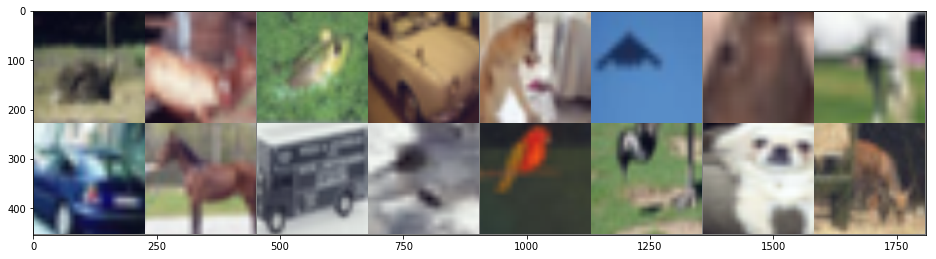

In [191]:
plt.figure (figsize = (16, 12))

plt.imshow(img)
plt.show()